# Baseline Results for Uni-modal Approaches

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 

from pathlib import Path
from sklearn.model_selection import KFold
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D,  MaxPooling1D, ConvLSTM2D
from tensorflow.keras import models

warnings.filterwarnings("ignore")

In [2]:
def load_file(file, prediction_type):
    df = pd.read_csv(file, header=0)
    labels = df[prediction_type]
    df = df.drop(columns=['pain_area', 'pain_level'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df.to_numpy(), labels

def reshape_CNN_data(X, n_length, n_features):
    return X.reshape((len(X), 1, n_length, n_features))

def reshape_LSTM_data(X, n_length, n_features):
    return X.reshape((len(X), 1, 1, n_length, n_features))

def load_dataset(input_filepath, prediction_type, modality, architecture):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_train = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_train = reshape_LSTM_data(X, n_length, n_features)
    y_train = pd.get_dummies(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file, prediction_type)
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    if architecture == 'CNN':
        X_test = reshape_CNN_data(X, n_length, n_features)
    elif architecture == 'convLSTM':
        X_test = reshape_LSTM_data(X, n_length, n_features)
    y_test = pd.get_dummies(y)
    y_test, tmp = y_test.align(y_train, join='outer', axis=1, fill_value=0)
    return X_train, X_test, y_train, y_test

In [3]:
accuracies = []
aucs = []
model_names = ['M1.1', 'M1.2', 'M1.3', 'M1.4', 'M2.1', 'M2.2', 'M2.3', 'M2.4']

## 1. Body Modality (Skeleton)

### 1.1 Pain area prediction - CNN+LSTM

#### Dataset

In [4]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'skeleton', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 38) (534, 5)
(81, 1, 350, 38) (81, 5)


##### Pain Classes

In [5]:
y_train.columns.tolist()

['BackPain', 'FootPain', 'HeadNeckPain', 'LowerBodyPain', 'UpperBodyPain']

#### Model

In [6]:
epochs, batch_size = 25, 256
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [7]:
def get_CNN_model(n_features, n_outputs, n_length):
    model = models.Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3,
        activation='relu'), input_shape=(None, n_length, n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [8]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 3, 64)      7360      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 3, 32)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 96)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               78800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                        

#### KFold CV

Epoch 1/25
2/2 - 3s - loss: 1.5149 - accuracy: 0.3989 - auc_1: 0.6603 - val_loss: 1.4231 - val_accuracy: 0.5337 - val_auc_1: 0.7187 - 3s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 1.4061 - accuracy: 0.5702 - auc_1: 0.7092 - val_loss: 1.3843 - val_accuracy: 0.5337 - val_auc_1: 0.7188 - 230ms/epoch - 115ms/step
Epoch 3/25
2/2 - 0s - loss: 1.3450 - accuracy: 0.5702 - auc_1: 0.7196 - val_loss: 1.3651 - val_accuracy: 0.5337 - val_auc_1: 0.7044 - 234ms/epoch - 117ms/step
Epoch 4/25
2/2 - 0s - loss: 1.3175 - accuracy: 0.5702 - auc_1: 0.7095 - val_loss: 1.3408 - val_accuracy: 0.5337 - val_auc_1: 0.7247 - 269ms/epoch - 134ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2895 - accuracy: 0.5702 - auc_1: 0.7366 - val_loss: 1.3241 - val_accuracy: 0.5337 - val_auc_1: 0.7479 - 227ms/epoch - 114ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2742 - accuracy: 0.5702 - auc_1: 0.7602 - val_loss: 1.3066 - val_accuracy: 0.5337 - val_auc_1: 0.7711 - 337ms/epoch - 168ms/step
Epoch 7/25
2/2 - 0s - loss: 1.2625 - accuracy: 0.570

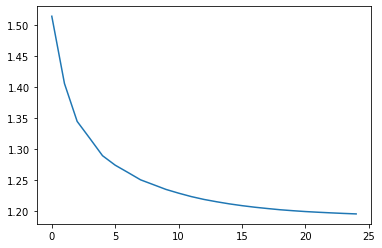

Epoch 1/25
2/2 - 3s - loss: 1.7293 - accuracy: 0.0871 - auc_2: 0.4085 - val_loss: 1.5179 - val_accuracy: 0.1742 - val_auc_2: 0.7004 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 1.5036 - accuracy: 0.3230 - auc_2: 0.7316 - val_loss: 1.4200 - val_accuracy: 0.5787 - val_auc_2: 0.7985 - 292ms/epoch - 146ms/step
Epoch 3/25
2/2 - 0s - loss: 1.4199 - accuracy: 0.5478 - auc_2: 0.7821 - val_loss: 1.3122 - val_accuracy: 0.5787 - val_auc_2: 0.8025 - 247ms/epoch - 123ms/step
Epoch 4/25
2/2 - 0s - loss: 1.3252 - accuracy: 0.5478 - auc_2: 0.7927 - val_loss: 1.2731 - val_accuracy: 0.5787 - val_auc_2: 0.8016 - 355ms/epoch - 178ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2927 - accuracy: 0.5478 - auc_2: 0.7867 - val_loss: 1.2433 - val_accuracy: 0.5787 - val_auc_2: 0.8014 - 296ms/epoch - 148ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2668 - accuracy: 0.5478 - auc_2: 0.7888 - val_loss: 1.2224 - val_accuracy: 0.5787 - val_auc_2: 0.8016 - 228ms/epoch - 114ms/step
Epoch 7/25
2/2 - 0s - loss: 1.2480 - accuracy: 0.547

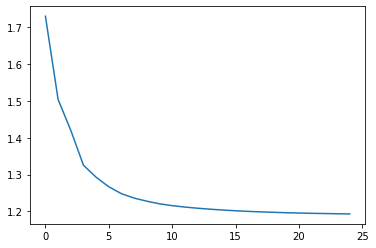

Epoch 1/25
2/2 - 2s - loss: 1.6558 - accuracy: 0.1826 - auc_3: 0.4832 - val_loss: 1.3646 - val_accuracy: 0.5618 - val_auc_3: 0.7956 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 1.3378 - accuracy: 0.5562 - auc_3: 0.7941 - val_loss: 1.2732 - val_accuracy: 0.5618 - val_auc_3: 0.7648 - 257ms/epoch - 129ms/step
Epoch 3/25
2/2 - 0s - loss: 1.2599 - accuracy: 0.5562 - auc_3: 0.7784 - val_loss: 1.2460 - val_accuracy: 0.5618 - val_auc_3: 0.7963 - 240ms/epoch - 120ms/step
Epoch 4/25
2/2 - 0s - loss: 1.2362 - accuracy: 0.5562 - auc_3: 0.8071 - val_loss: 1.2288 - val_accuracy: 0.5618 - val_auc_3: 0.7963 - 241ms/epoch - 120ms/step
Epoch 5/25
2/2 - 0s - loss: 1.2190 - accuracy: 0.5562 - auc_3: 0.8106 - val_loss: 1.2176 - val_accuracy: 0.5618 - val_auc_3: 0.7957 - 241ms/epoch - 121ms/step
Epoch 6/25
2/2 - 0s - loss: 1.2088 - accuracy: 0.5562 - auc_3: 0.8054 - val_loss: 1.2089 - val_accuracy: 0.5618 - val_auc_3: 0.7963 - 259ms/epoch - 130ms/step
Epoch 7/25
2/2 - 0s - loss: 1.1994 - accuracy: 0.556

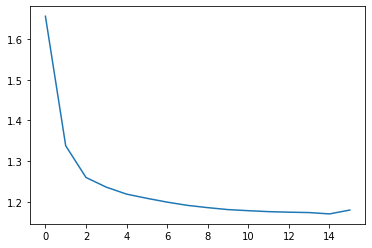

In [9]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [10]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 50.617%

AUC: 0.7933


### 1.2 Pain area detection - Convolutional LSTM

#### Dataset

In [11]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'skeleton', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 1, 350, 38) (534, 5)
(81, 1, 1, 350, 38) (81, 5)


#### Model

In [12]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [13]:
def get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length):
    model = models.Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(
        1, 3), activation='relu', input_shape=(n_timesteps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=50,
        decay_rate=0.1)
    optimizer = optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='categorical_crossentropy',
        optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

def train(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2)
    return history

In [14]:
model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 348, 64)        78592     
                                                                 
 flatten_4 (Flatten)         (None, 22272)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               2227300   
                                                                 
 dense_9 (Dense)             (None, 5)                 505       
                                                                 
Total params: 2,306,397
Trainable params: 2,306,397
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
2/2 - 3s - loss: 183.0403 - accuracy: 0.3146 - auc_5: 0.5716 - val_loss: 357.1748 - val_accuracy: 0.0449 - val_auc_5: 0.3910 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 1s - loss: 267.5304 - accuracy: 0.0927 - auc_5: 0.4272 - val_loss: 138.8231 - val_accuracy: 0.5337 - val_auc_5: 0.7086 - 978ms/epoch - 489ms/step
Epoch 3/25
2/2 - 1s - loss: 115.6630 - accuracy: 0.5702 - auc_5: 0.7314 - val_loss: 75.2747 - val_accuracy: 0.5337 - val_auc_5: 0.7086 - 1s/epoch - 552ms/step
Epoch 4/25
2/2 - 1s - loss: 61.0463 - accuracy: 0.5393 - auc_5: 0.7150 - val_loss: 26.1519 - val_accuracy: 0.3933 - val_auc_5: 0.6251 - 1s/epoch - 654ms/step
Epoch 5/25
2/2 - 1s - loss: 22.5502 - accuracy: 0.4382 - auc_5: 0.6634 - val_loss: 9.9032 - val_accuracy: 0.4382 - val_auc_5: 0.6617 - 1s/epoch - 629ms/step
Epoch 6/25
2/2 - 1s - loss: 9.8221 - accuracy: 0.4354 - auc_5: 0.6696 - val_loss: 5.5403 - val_accuracy: 0.5112 - val_auc_5: 0.7185 - 1s/epoch - 564ms/step
Epoch 7/25
2/2 - 1s - loss: 5.3364 - accuracy: 0.4

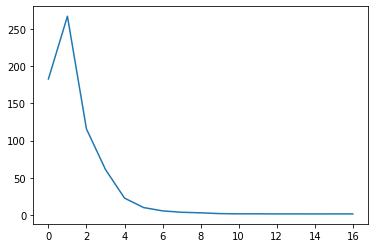

Epoch 1/25
2/2 - 4s - loss: 24.5632 - accuracy: 0.3427 - auc_6: 0.6091 - val_loss: 23.4895 - val_accuracy: 0.2247 - val_auc_6: 0.5099 - 4s/epoch - 2s/step
Epoch 2/25
2/2 - 1s - loss: 16.7199 - accuracy: 0.2584 - auc_6: 0.5513 - val_loss: 3.4708 - val_accuracy: 0.3315 - val_auc_6: 0.6184 - 873ms/epoch - 436ms/step
Epoch 3/25
2/2 - 1s - loss: 2.7453 - accuracy: 0.3596 - auc_6: 0.6122 - val_loss: 2.3757 - val_accuracy: 0.5674 - val_auc_6: 0.7227 - 1s/epoch - 567ms/step
Epoch 4/25
2/2 - 1s - loss: 1.6036 - accuracy: 0.5562 - auc_6: 0.7316 - val_loss: 1.8216 - val_accuracy: 0.5674 - val_auc_6: 0.7276 - 1s/epoch - 501ms/step
Epoch 5/25
2/2 - 1s - loss: 1.5717 - accuracy: 0.5646 - auc_6: 0.7389 - val_loss: 1.8557 - val_accuracy: 0.5674 - val_auc_6: 0.7229 - 919ms/epoch - 459ms/step
Epoch 6/25
2/2 - 1s - loss: 1.5236 - accuracy: 0.5702 - auc_6: 0.7482 - val_loss: 1.8877 - val_accuracy: 0.5674 - val_auc_6: 0.7209 - 819ms/epoch - 410ms/step


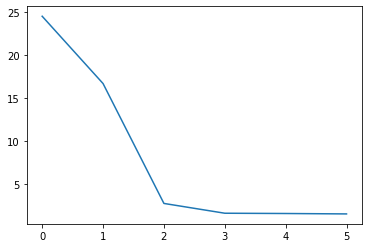

Epoch 1/25
2/2 - 3s - loss: 98.1238 - accuracy: 0.2219 - auc_7: 0.5135 - val_loss: 344.4907 - val_accuracy: 0.1854 - val_auc_7: 0.4956 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 1s - loss: 362.4948 - accuracy: 0.1966 - auc_7: 0.4965 - val_loss: 475.0177 - val_accuracy: 0.0730 - val_auc_7: 0.4206 - 920ms/epoch - 460ms/step
Epoch 3/25
2/2 - 1s - loss: 396.7061 - accuracy: 0.1994 - auc_7: 0.4996 - val_loss: 193.2589 - val_accuracy: 0.5618 - val_auc_7: 0.7261 - 1s/epoch - 624ms/step
Epoch 4/25
2/2 - 1s - loss: 183.6008 - accuracy: 0.5562 - auc_7: 0.7226 - val_loss: 138.7763 - val_accuracy: 0.5618 - val_auc_7: 0.7261 - 1s/epoch - 603ms/step
Epoch 5/25
2/2 - 1s - loss: 125.5604 - accuracy: 0.5562 - auc_7: 0.7226 - val_loss: 69.5349 - val_accuracy: 0.5112 - val_auc_7: 0.7166 - 1s/epoch - 596ms/step
Epoch 6/25
2/2 - 1s - loss: 65.4780 - accuracy: 0.4466 - auc_7: 0.6687 - val_loss: 54.5386 - val_accuracy: 0.1573 - val_auc_7: 0.4733 - 1s/epoch - 606ms/step
Epoch 7/25
2/2 - 1s - loss: 46.3840 - accura

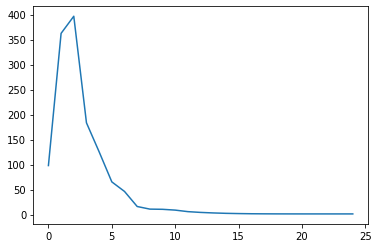

In [15]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [16]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 49.383%

AUC: 0.6915


### 1.3 Pain level detection - CNN+LSTM

#### Dataset

In [17]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'skeleton', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 350, 38) (534, 3)
(81, 1, 350, 38) (81, 3)


##### Pain classes

In [18]:
y_train.columns.tolist()

['Mild', 'Moderate', 'Severe']

#### Model

In [19]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [20]:
model = get_CNN_model(n_features, n_outputs, n_length)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, None, 348, 64)    7360      
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, None, 348, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, None, 11136)      0         
 stributed)                                                      
                                                                 
 lstm_4 (LSTM)               (None, 100)               4494800   
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                      

#### KFold CV

Epoch 1/25
2/2 - 2s - loss: 1.1502 - accuracy: 0.3202 - auc_9: 0.4950 - val_loss: 0.8648 - val_accuracy: 0.6629 - val_auc_9: 0.8190 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 0.8402 - accuracy: 0.6320 - auc_9: 0.8063 - val_loss: 0.8062 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 379ms/epoch - 190ms/step
Epoch 3/25
2/2 - 0s - loss: 0.7885 - accuracy: 0.6320 - auc_9: 0.8199 - val_loss: 0.7739 - val_accuracy: 0.6629 - val_auc_9: 0.8156 - 242ms/epoch - 121ms/step
Epoch 4/25
2/2 - 0s - loss: 0.7644 - accuracy: 0.6320 - auc_9: 0.8164 - val_loss: 0.7522 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 391ms/epoch - 196ms/step
Epoch 5/25
2/2 - 0s - loss: 0.7565 - accuracy: 0.6320 - auc_9: 0.8143 - val_loss: 0.7479 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 234ms/epoch - 117ms/step
Epoch 6/25
2/2 - 0s - loss: 0.7551 - accuracy: 0.6320 - auc_9: 0.8099 - val_loss: 0.7440 - val_accuracy: 0.6629 - val_auc_9: 0.8174 - 247ms/epoch - 124ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7468 - accuracy: 0.632

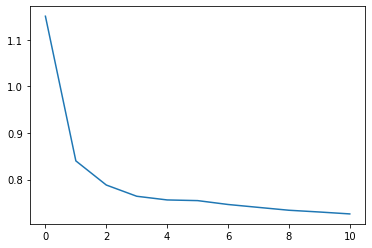

Epoch 1/25
2/2 - 3s - loss: 1.0852 - accuracy: 0.3315 - auc_10: 0.6339 - val_loss: 0.9685 - val_accuracy: 0.3652 - val_auc_10: 0.6834 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 0s - loss: 0.9755 - accuracy: 0.4242 - auc_10: 0.6675 - val_loss: 0.9187 - val_accuracy: 0.6348 - val_auc_10: 0.8123 - 250ms/epoch - 125ms/step
Epoch 3/25
2/2 - 0s - loss: 0.9195 - accuracy: 0.6489 - auc_10: 0.8186 - val_loss: 0.8735 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 230ms/epoch - 115ms/step
Epoch 4/25
2/2 - 0s - loss: 0.8736 - accuracy: 0.6489 - auc_10: 0.8288 - val_loss: 0.8406 - val_accuracy: 0.6292 - val_auc_10: 0.8127 - 312ms/epoch - 156ms/step
Epoch 5/25
2/2 - 0s - loss: 0.8431 - accuracy: 0.6489 - auc_10: 0.8135 - val_loss: 0.8033 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 256ms/epoch - 128ms/step
Epoch 6/25
2/2 - 0s - loss: 0.8092 - accuracy: 0.6489 - auc_10: 0.8106 - val_loss: 0.7864 - val_accuracy: 0.6292 - val_auc_10: 0.8118 - 227ms/epoch - 114ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7928 - acc

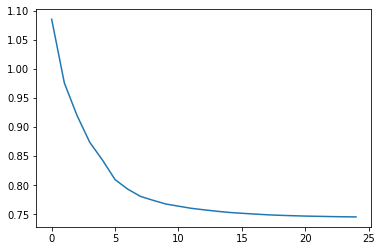

Epoch 1/25
2/2 - 2s - loss: 1.0580 - accuracy: 0.4719 - auc_11: 0.6085 - val_loss: 0.8177 - val_accuracy: 0.6348 - val_auc_11: 0.8059 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 0s - loss: 0.8050 - accuracy: 0.6461 - auc_11: 0.8113 - val_loss: 0.7897 - val_accuracy: 0.6348 - val_auc_11: 0.8062 - 249ms/epoch - 124ms/step
Epoch 3/25
2/2 - 0s - loss: 0.7724 - accuracy: 0.6461 - auc_11: 0.8147 - val_loss: 0.7714 - val_accuracy: 0.6348 - val_auc_11: 0.8071 - 306ms/epoch - 153ms/step
Epoch 4/25
2/2 - 0s - loss: 0.7534 - accuracy: 0.6461 - auc_11: 0.8156 - val_loss: 0.7594 - val_accuracy: 0.6348 - val_auc_11: 0.8057 - 231ms/epoch - 116ms/step
Epoch 5/25
2/2 - 0s - loss: 0.7408 - accuracy: 0.6461 - auc_11: 0.8160 - val_loss: 0.7525 - val_accuracy: 0.6348 - val_auc_11: 0.8037 - 231ms/epoch - 115ms/step
Epoch 6/25
2/2 - 0s - loss: 0.7333 - accuracy: 0.6461 - auc_11: 0.8175 - val_loss: 0.7474 - val_accuracy: 0.6348 - val_auc_11: 0.8057 - 227ms/epoch - 113ms/step
Epoch 7/25
2/2 - 0s - loss: 0.7284 - acc

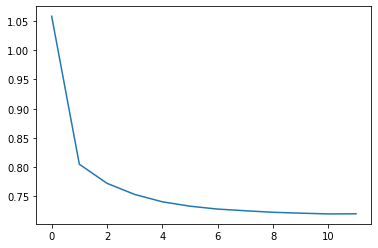

In [21]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [22]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 77.778%

AUC: 0.8704


### 1.4 Pain level detection - Convolutional LSTM

#### Dataset

In [23]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'skeleton', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(534, 1, 1, 350, 38) (534, 3)
(81, 1, 1, 350, 38) (81, 3)


#### Model

In [24]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [25]:
model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 1, 348, 64)        78592     
                                                                 
 flatten_12 (Flatten)        (None, 22272)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               2227300   
                                                                 
 dense_25 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,306,195
Trainable params: 2,306,195
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
2/2 - 3s - loss: 119.5187 - accuracy: 0.5421 - auc_13: 0.6566 - val_loss: 93.7481 - val_accuracy: 0.3034 - val_auc_13: 0.4735 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 1s - loss: 81.8505 - accuracy: 0.2781 - auc_13: 0.4530 - val_loss: 4.1727 - val_accuracy: 0.2809 - val_auc_13: 0.5076 - 812ms/epoch - 406ms/step
Epoch 3/25
2/2 - 1s - loss: 4.2157 - accuracy: 0.3034 - auc_13: 0.4614 - val_loss: 1.2384 - val_accuracy: 0.6404 - val_auc_13: 0.5232 - 802ms/epoch - 401ms/step
Epoch 4/25
2/2 - 1s - loss: 1.3548 - accuracy: 0.6208 - auc_13: 0.5183 - val_loss: 1.0887 - val_accuracy: 0.6517 - val_auc_13: 0.5111 - 799ms/epoch - 400ms/step
Epoch 5/25
2/2 - 1s - loss: 1.0960 - accuracy: 0.6320 - auc_13: 0.5125 - val_loss: 1.0876 - val_accuracy: 0.6573 - val_auc_13: 0.5084 - 809ms/epoch - 405ms/step
Epoch 6/25
2/2 - 1s - loss: 1.0905 - accuracy: 0.6264 - auc_13: 0.5745 - val_loss: 1.0865 - val_accuracy: 0.6573 - val_auc_13: 0.8167 - 1s/epoch - 609ms/step
Epoch 7/25
2/2 - 1s - loss: 1.0891 - ac

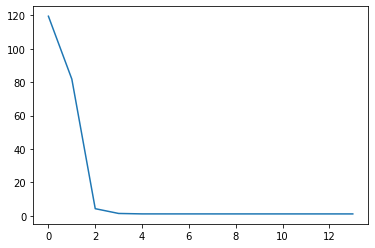

Epoch 1/25
2/2 - 2s - loss: 332.3224 - accuracy: 0.3820 - auc_14: 0.5365 - val_loss: 612.0973 - val_accuracy: 0.6292 - val_auc_14: 0.7219 - 2s/epoch - 1s/step
Epoch 2/25
2/2 - 1s - loss: 475.0893 - accuracy: 0.5674 - auc_14: 0.6863 - val_loss: 167.5811 - val_accuracy: 0.6292 - val_auc_14: 0.7219 - 812ms/epoch - 406ms/step
Epoch 3/25
2/2 - 1s - loss: 122.4089 - accuracy: 0.6461 - auc_14: 0.7362 - val_loss: 88.5714 - val_accuracy: 0.3652 - val_auc_14: 0.5239 - 989ms/epoch - 495ms/step
Epoch 4/25
2/2 - 1s - loss: 99.8966 - accuracy: 0.3258 - auc_14: 0.4944 - val_loss: 66.3154 - val_accuracy: 0.3652 - val_auc_14: 0.5239 - 872ms/epoch - 436ms/step
Epoch 5/25
2/2 - 1s - loss: 67.0857 - accuracy: 0.3258 - auc_14: 0.4944 - val_loss: 6.9248 - val_accuracy: 0.6236 - val_auc_14: 0.7373 - 777ms/epoch - 389ms/step
Epoch 6/25
2/2 - 1s - loss: 19.6936 - accuracy: 0.6489 - auc_14: 0.7426 - val_loss: 26.8140 - val_accuracy: 0.6292 - val_auc_14: 0.7219 - 723ms/epoch - 361ms/step
Epoch 7/25
2/2 - 1s - lo

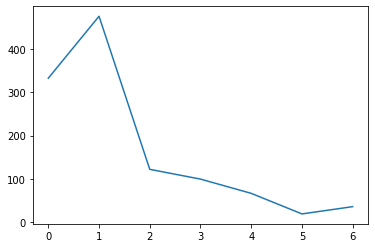

Epoch 1/25
2/2 - 3s - loss: 128.8842 - accuracy: 0.1208 - auc_15: 0.3406 - val_loss: 266.4784 - val_accuracy: 0.6348 - val_auc_15: 0.7261 - 3s/epoch - 2s/step
Epoch 2/25
2/2 - 1s - loss: 241.3210 - accuracy: 0.6461 - auc_15: 0.7346 - val_loss: 138.9606 - val_accuracy: 0.6348 - val_auc_15: 0.7261 - 891ms/epoch - 445ms/step
Epoch 3/25
2/2 - 1s - loss: 115.9408 - accuracy: 0.6461 - auc_15: 0.7346 - val_loss: 38.6149 - val_accuracy: 0.5562 - val_auc_15: 0.6731 - 773ms/epoch - 387ms/step
Epoch 4/25
2/2 - 1s - loss: 33.5518 - accuracy: 0.5506 - auc_15: 0.6641 - val_loss: 33.8356 - val_accuracy: 0.3427 - val_auc_15: 0.5126 - 854ms/epoch - 427ms/step
Epoch 5/25
2/2 - 1s - loss: 24.9914 - accuracy: 0.3399 - auc_15: 0.5260 - val_loss: 6.8344 - val_accuracy: 0.3708 - val_auc_15: 0.5747 - 765ms/epoch - 382ms/step
Epoch 6/25
2/2 - 1s - loss: 3.9805 - accuracy: 0.4382 - auc_15: 0.6139 - val_loss: 3.7510 - val_accuracy: 0.5843 - val_auc_15: 0.7172 - 738ms/epoch - 369ms/step
Epoch 7/25
2/2 - 1s - loss

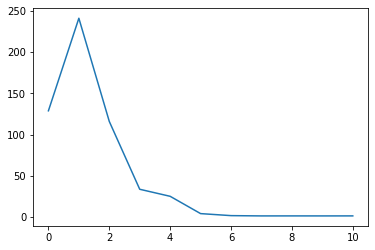

In [26]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [27]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 76.543%

AUC: 0.8536


## 2. Face Modality (Action Units)

### 2.1 Pain area prediction - CNN+LSTM

#### Dataset

In [28]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'AUs', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 350, 10) (208, 5)
(27, 1, 350, 10) (27, 5)


#### Model

In [29]:
batch_size = 68
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [30]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, None, 3, 64)      1984      
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, None, 3, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, None, 96)         0         
 stributed)                                                      
                                                                 
 lstm_8 (LSTM)               (None, 100)               78800     
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                     

#### KFold CV

Epoch 1/25
3/3 - 2s - loss: 1.4773 - accuracy: 0.5072 - auc_17: 0.7160 - val_loss: 1.3107 - val_accuracy: 0.5000 - val_auc_17: 0.7518 - 2s/epoch - 730ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2626 - accuracy: 0.5217 - auc_17: 0.7909 - val_loss: 1.2692 - val_accuracy: 0.5000 - val_auc_17: 0.8020 - 125ms/epoch - 42ms/step
Epoch 3/25
3/3 - 0s - loss: 1.2560 - accuracy: 0.5217 - auc_17: 0.8044 - val_loss: 1.2732 - val_accuracy: 0.5000 - val_auc_17: 0.7962 - 129ms/epoch - 43ms/step
Epoch 4/25
3/3 - 0s - loss: 1.2430 - accuracy: 0.5217 - auc_17: 0.8096 - val_loss: 1.2735 - val_accuracy: 0.5000 - val_auc_17: 0.7776 - 136ms/epoch - 45ms/step


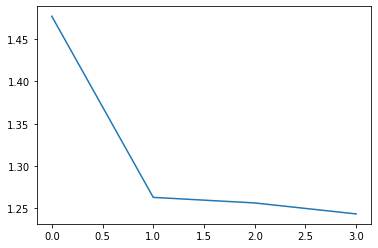

Epoch 1/25
3/3 - 2s - loss: 1.5050 - accuracy: 0.3022 - auc_18: 0.6048 - val_loss: 1.3385 - val_accuracy: 0.4638 - val_auc_18: 0.7688 - 2s/epoch - 625ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2444 - accuracy: 0.5036 - auc_18: 0.8046 - val_loss: 1.2771 - val_accuracy: 0.4928 - val_auc_18: 0.7813 - 134ms/epoch - 45ms/step
Epoch 3/25
3/3 - 0s - loss: 1.2144 - accuracy: 0.5252 - auc_18: 0.8111 - val_loss: 1.2690 - val_accuracy: 0.4928 - val_auc_18: 0.7862 - 133ms/epoch - 44ms/step
Epoch 4/25
3/3 - 0s - loss: 1.2262 - accuracy: 0.5252 - auc_18: 0.8212 - val_loss: 1.2805 - val_accuracy: 0.4928 - val_auc_18: 0.7869 - 139ms/epoch - 46ms/step
Epoch 5/25
3/3 - 0s - loss: 1.2197 - accuracy: 0.5252 - auc_18: 0.8317 - val_loss: 1.2805 - val_accuracy: 0.4928 - val_auc_18: 0.7873 - 138ms/epoch - 46ms/step


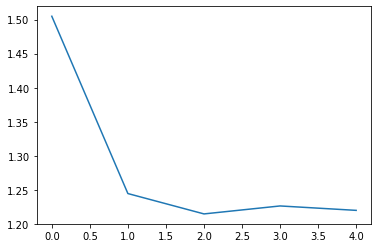

Epoch 1/25
3/3 - 2s - loss: 1.4933 - accuracy: 0.3597 - auc_19: 0.6802 - val_loss: 1.2924 - val_accuracy: 0.5507 - val_auc_19: 0.7799 - 2s/epoch - 646ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2741 - accuracy: 0.4964 - auc_19: 0.7958 - val_loss: 1.2651 - val_accuracy: 0.5507 - val_auc_19: 0.7790 - 149ms/epoch - 50ms/step
Epoch 3/25
3/3 - 0s - loss: 1.2472 - accuracy: 0.4964 - auc_19: 0.8112 - val_loss: 1.2361 - val_accuracy: 0.5507 - val_auc_19: 0.7792 - 165ms/epoch - 55ms/step
Epoch 4/25
3/3 - 0s - loss: 1.2352 - accuracy: 0.4964 - auc_19: 0.8101 - val_loss: 1.2329 - val_accuracy: 0.5507 - val_auc_19: 0.7889 - 136ms/epoch - 45ms/step
Epoch 5/25
3/3 - 0s - loss: 1.2354 - accuracy: 0.4964 - auc_19: 0.8236 - val_loss: 1.2368 - val_accuracy: 0.5507 - val_auc_19: 0.7992 - 134ms/epoch - 45ms/step
Epoch 6/25
3/3 - 0s - loss: 1.2324 - accuracy: 0.4964 - auc_19: 0.8221 - val_loss: 1.2363 - val_accuracy: 0.5507 - val_auc_19: 0.7926 - 128ms/epoch - 43ms/step


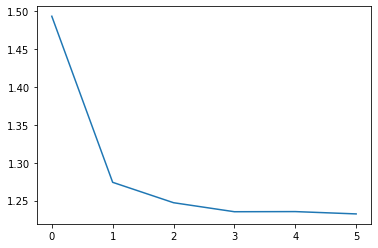

In [31]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [32]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 66.667%

AUC: 0.8469


### 2.2 Pain area prediction - Convolutional LSTM

#### Dataset

In [33]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_area', 'AUs', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 1, 350, 10) (208, 5)
(27, 1, 1, 350, 10) (27, 5)


#### Model

In [34]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [35]:
model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_8 (ConvLSTM2D)  (None, 1, 348, 64)        57088     
                                                                 
 flatten_20 (Flatten)        (None, 22272)             0         
                                                                 
 dense_40 (Dense)            (None, 100)               2227300   
                                                                 
 dense_41 (Dense)            (None, 5)                 505       
                                                                 
Total params: 2,284,893
Trainable params: 2,284,893
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
3/3 - 2s - loss: 1.4588 - accuracy: 0.3768 - auc_21: 0.6935 - val_loss: 1.4839 - val_accuracy: 0.5000 - val_auc_21: 0.7190 - 2s/epoch - 775ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2871 - accuracy: 0.5217 - auc_21: 0.7860 - val_loss: 1.3461 - val_accuracy: 0.5000 - val_auc_21: 0.7404 - 349ms/epoch - 116ms/step
Epoch 3/25
3/3 - 0s - loss: 1.1934 - accuracy: 0.5217 - auc_21: 0.8153 - val_loss: 1.2894 - val_accuracy: 0.4571 - val_auc_21: 0.7706 - 315ms/epoch - 105ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1836 - accuracy: 0.5217 - auc_21: 0.8324 - val_loss: 1.2611 - val_accuracy: 0.5143 - val_auc_21: 0.7760 - 293ms/epoch - 98ms/step
Epoch 5/25
3/3 - 0s - loss: 1.1665 - accuracy: 0.5290 - auc_21: 0.8276 - val_loss: 1.2573 - val_accuracy: 0.5143 - val_auc_21: 0.7771 - 299ms/epoch - 100ms/step
Epoch 6/25
3/3 - 0s - loss: 1.1306 - accuracy: 0.5362 - auc_21: 0.8333 - val_loss: 1.2571 - val_accuracy: 0.5143 - val_auc_21: 0.7858 - 365ms/epoch - 122ms/step
Epoch 7/25
3/3 - 0s - loss: 1.0955 - a

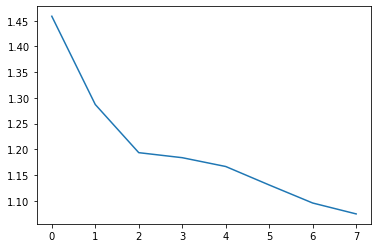

Epoch 1/25
3/3 - 2s - loss: 1.5296 - accuracy: 0.3022 - auc_22: 0.6506 - val_loss: 1.2589 - val_accuracy: 0.4928 - val_auc_22: 0.7869 - 2s/epoch - 809ms/step
Epoch 2/25
3/3 - 0s - loss: 1.2088 - accuracy: 0.5252 - auc_22: 0.8145 - val_loss: 1.2480 - val_accuracy: 0.4928 - val_auc_22: 0.7816 - 440ms/epoch - 147ms/step
Epoch 3/25
3/3 - 0s - loss: 1.1420 - accuracy: 0.5540 - auc_22: 0.8383 - val_loss: 1.2795 - val_accuracy: 0.5072 - val_auc_22: 0.7637 - 305ms/epoch - 102ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1046 - accuracy: 0.5755 - auc_22: 0.8448 - val_loss: 1.2561 - val_accuracy: 0.4928 - val_auc_22: 0.7768 - 459ms/epoch - 153ms/step


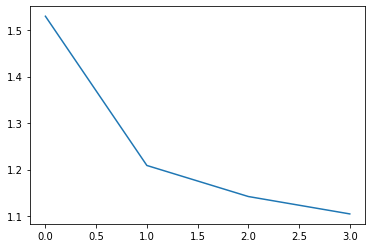

Epoch 1/25
3/3 - 2s - loss: 1.4725 - accuracy: 0.2950 - auc_23: 0.6515 - val_loss: 1.2764 - val_accuracy: 0.5507 - val_auc_23: 0.7929 - 2s/epoch - 791ms/step
Epoch 2/25
3/3 - 0s - loss: 1.3890 - accuracy: 0.4964 - auc_23: 0.7850 - val_loss: 1.2520 - val_accuracy: 0.5652 - val_auc_23: 0.7940 - 388ms/epoch - 129ms/step
Epoch 3/25
3/3 - 0s - loss: 1.1573 - accuracy: 0.5324 - auc_23: 0.8238 - val_loss: 1.3021 - val_accuracy: 0.4203 - val_auc_23: 0.7689 - 375ms/epoch - 125ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1342 - accuracy: 0.4820 - auc_23: 0.8307 - val_loss: 1.3425 - val_accuracy: 0.4348 - val_auc_23: 0.7524 - 347ms/epoch - 116ms/step


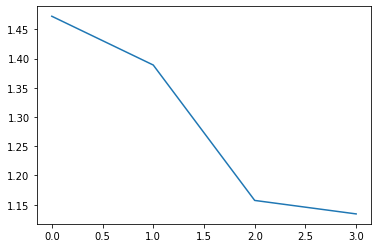

In [36]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [37]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 51.852%

AUC: 0.8083


### 2.3 Pain level prediction - CNN+LSTM

#### Dataset

In [38]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'AUs', 'CNN')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 350, 10) (208, 3)
(27, 1, 350, 10) (27, 3)


#### Model

In [39]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [40]:
model = get_CNN_model(n_features, n_length, n_outputs)
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, None, 1, 64)      1984      
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, None, 1, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, None, 32)         0         
 stributed)                                                      
                                                                 
 lstm_12 (LSTM)              (None, 100)               53200     
                                                                 
 dense_48 (Dense)            (None, 100)               10100     
                                                     

#### KFold CV

Epoch 1/25
3/3 - 3s - loss: 0.9277 - accuracy: 0.3913 - auc_25: 0.6532 - val_loss: 0.8489 - val_accuracy: 0.5714 - val_auc_25: 0.8082 - 3s/epoch - 839ms/step
Epoch 2/25
3/3 - 0s - loss: 0.6599 - accuracy: 0.6884 - auc_25: 0.8866 - val_loss: 0.7757 - val_accuracy: 0.5714 - val_auc_25: 0.8128 - 133ms/epoch - 44ms/step
Epoch 3/25
3/3 - 0s - loss: 0.6083 - accuracy: 0.6884 - auc_25: 0.8922 - val_loss: 0.7645 - val_accuracy: 0.5714 - val_auc_25: 0.8138 - 133ms/epoch - 44ms/step
Epoch 4/25
3/3 - 0s - loss: 0.5898 - accuracy: 0.6884 - auc_25: 0.8924 - val_loss: 0.7440 - val_accuracy: 0.6000 - val_auc_25: 0.8141 - 136ms/epoch - 45ms/step
Epoch 5/25
3/3 - 0s - loss: 0.5825 - accuracy: 0.7464 - auc_25: 0.8997 - val_loss: 0.7377 - val_accuracy: 0.5857 - val_auc_25: 0.8134 - 135ms/epoch - 45ms/step
Epoch 6/25
3/3 - 0s - loss: 0.5784 - accuracy: 0.7391 - auc_25: 0.9035 - val_loss: 0.7392 - val_accuracy: 0.5714 - val_auc_25: 0.8155 - 136ms/epoch - 45ms/step
Epoch 7/25
3/3 - 0s - loss: 0.5713 - accur

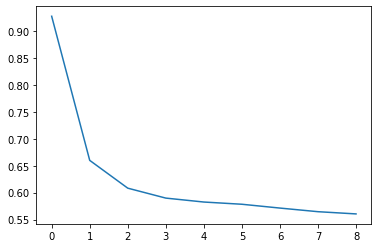

Epoch 1/25
3/3 - 2s - loss: 0.8905 - accuracy: 0.6259 - auc_26: 0.7611 - val_loss: 0.7982 - val_accuracy: 0.3478 - val_auc_26: 0.6936 - 2s/epoch - 687ms/step
Epoch 2/25
3/3 - 0s - loss: 0.7650 - accuracy: 0.3813 - auc_26: 0.7099 - val_loss: 0.7383 - val_accuracy: 0.6377 - val_auc_26: 0.8227 - 138ms/epoch - 46ms/step
Epoch 3/25
3/3 - 0s - loss: 0.7014 - accuracy: 0.6043 - auc_26: 0.8390 - val_loss: 0.7216 - val_accuracy: 0.6087 - val_auc_26: 0.8271 - 147ms/epoch - 49ms/step
Epoch 4/25
3/3 - 0s - loss: 0.6821 - accuracy: 0.6619 - auc_26: 0.8557 - val_loss: 0.7137 - val_accuracy: 0.6522 - val_auc_26: 0.8344 - 156ms/epoch - 52ms/step
Epoch 5/25
3/3 - 0s - loss: 0.6625 - accuracy: 0.6906 - auc_26: 0.8678 - val_loss: 0.7044 - val_accuracy: 0.6087 - val_auc_26: 0.8379 - 159ms/epoch - 53ms/step
Epoch 6/25
3/3 - 0s - loss: 0.6484 - accuracy: 0.6403 - auc_26: 0.8650 - val_loss: 0.7193 - val_accuracy: 0.6087 - val_auc_26: 0.8425 - 149ms/epoch - 50ms/step
Epoch 7/25
3/3 - 0s - loss: 0.6509 - accur

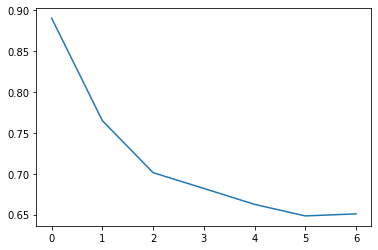

Epoch 1/25
3/3 - 3s - loss: 1.0746 - accuracy: 0.5324 - auc_27: 0.6841 - val_loss: 0.7503 - val_accuracy: 0.7246 - val_auc_27: 0.9046 - 3s/epoch - 880ms/step
Epoch 2/25
3/3 - 0s - loss: 0.8070 - accuracy: 0.6547 - auc_27: 0.8331 - val_loss: 0.7576 - val_accuracy: 0.6377 - val_auc_27: 0.8478 - 151ms/epoch - 50ms/step
Epoch 3/25
3/3 - 0s - loss: 0.7645 - accuracy: 0.6547 - auc_27: 0.8463 - val_loss: 0.6346 - val_accuracy: 0.6957 - val_auc_27: 0.9118 - 148ms/epoch - 49ms/step
Epoch 4/25
3/3 - 0s - loss: 0.7108 - accuracy: 0.6259 - auc_27: 0.8470 - val_loss: 0.5902 - val_accuracy: 0.7246 - val_auc_27: 0.9118 - 152ms/epoch - 51ms/step
Epoch 5/25
3/3 - 0s - loss: 0.7185 - accuracy: 0.6115 - auc_27: 0.8474 - val_loss: 0.5775 - val_accuracy: 0.7246 - val_auc_27: 0.9112 - 140ms/epoch - 47ms/step
Epoch 6/25
3/3 - 0s - loss: 0.7176 - accuracy: 0.6115 - auc_27: 0.8464 - val_loss: 0.5718 - val_accuracy: 0.7246 - val_auc_27: 0.9108 - 148ms/epoch - 49ms/step
Epoch 7/25
3/3 - 0s - loss: 0.6934 - accur

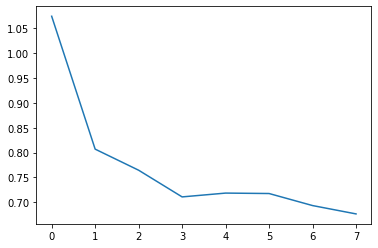

In [41]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_CNN_model(n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [42]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 70.370%

AUC: 0.928


### 2.4 Pain level prediction - Convolutional LSTM

#### Dataset

In [43]:
X_train, X_test, y_train, y_test = load_dataset('processed', 'pain_level', 'AUs', 'convLSTM')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(208, 1, 1, 350, 10) (208, 3)
(27, 1, 1, 350, 10) (27, 3)


#### Model

In [44]:
n_timesteps, n_length, n_features, n_outputs = X_train.shape[1], X_train.shape[3], X_train.shape[-1], y_train.shape[1]

In [45]:
model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 1, 348, 64)       57088     
                                                                 
 flatten_28 (Flatten)        (None, 22272)             0         
                                                                 
 dense_56 (Dense)            (None, 100)               2227300   
                                                                 
 dense_57 (Dense)            (None, 3)                 303       
                                                                 
Total params: 2,284,691
Trainable params: 2,284,691
Non-trainable params: 0
_________________________________________________________________


#### KFold CV

Epoch 1/25
3/3 - 3s - loss: 0.9564 - accuracy: 0.6594 - auc_29: 0.7719 - val_loss: 1.0840 - val_accuracy: 0.5714 - val_auc_29: 0.7855 - 3s/epoch - 1s/step
Epoch 2/25
3/3 - 0s - loss: 0.7000 - accuracy: 0.6884 - auc_29: 0.8790 - val_loss: 0.8201 - val_accuracy: 0.5714 - val_auc_29: 0.8118 - 419ms/epoch - 140ms/step
Epoch 3/25
3/3 - 0s - loss: 0.5755 - accuracy: 0.6884 - auc_29: 0.8971 - val_loss: 0.7524 - val_accuracy: 0.6000 - val_auc_29: 0.8229 - 379ms/epoch - 126ms/step
Epoch 4/25
3/3 - 0s - loss: 0.5420 - accuracy: 0.7826 - auc_29: 0.9123 - val_loss: 0.7390 - val_accuracy: 0.5714 - val_auc_29: 0.8317 - 383ms/epoch - 128ms/step
Epoch 5/25
3/3 - 0s - loss: 0.5342 - accuracy: 0.7609 - auc_29: 0.9200 - val_loss: 0.7665 - val_accuracy: 0.6143 - val_auc_29: 0.8320 - 382ms/epoch - 127ms/step
Epoch 6/25
3/3 - 0s - loss: 0.5129 - accuracy: 0.7681 - auc_29: 0.9239 - val_loss: 0.8706 - val_accuracy: 0.6000 - val_auc_29: 0.8201 - 324ms/epoch - 108ms/step


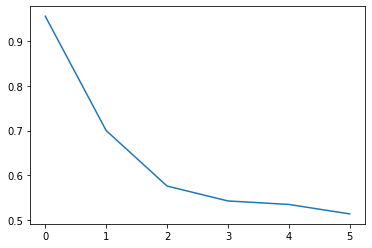

Epoch 1/25
3/3 - 2s - loss: 0.9513 - accuracy: 0.4173 - auc_30: 0.6348 - val_loss: 0.8366 - val_accuracy: 0.6522 - val_auc_30: 0.8545 - 2s/epoch - 803ms/step
Epoch 2/25
3/3 - 1s - loss: 0.7935 - accuracy: 0.6475 - auc_30: 0.8574 - val_loss: 0.7078 - val_accuracy: 0.6522 - val_auc_30: 0.8602 - 520ms/epoch - 173ms/step
Epoch 3/25
3/3 - 1s - loss: 0.6542 - accuracy: 0.6475 - auc_30: 0.8745 - val_loss: 0.6656 - val_accuracy: 0.6667 - val_auc_30: 0.8604 - 553ms/epoch - 184ms/step
Epoch 4/25
3/3 - 1s - loss: 0.6125 - accuracy: 0.7338 - auc_30: 0.9036 - val_loss: 0.6834 - val_accuracy: 0.6232 - val_auc_30: 0.8585 - 581ms/epoch - 194ms/step
Epoch 5/25
3/3 - 0s - loss: 0.6137 - accuracy: 0.7482 - auc_30: 0.9096 - val_loss: 0.6567 - val_accuracy: 0.7101 - val_auc_30: 0.8662 - 458ms/epoch - 153ms/step
Epoch 6/25
3/3 - 0s - loss: 0.5750 - accuracy: 0.7410 - auc_30: 0.9059 - val_loss: 0.6594 - val_accuracy: 0.6812 - val_auc_30: 0.8684 - 432ms/epoch - 144ms/step
Epoch 7/25
3/3 - 0s - loss: 0.5616 - 

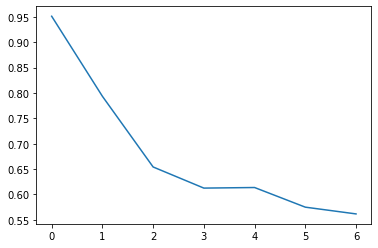

Epoch 1/25
3/3 - 3s - loss: 0.8814 - accuracy: 0.6187 - auc_31: 0.7938 - val_loss: 0.5465 - val_accuracy: 0.7246 - val_auc_31: 0.9098 - 3s/epoch - 867ms/step
Epoch 2/25
3/3 - 0s - loss: 0.6867 - accuracy: 0.7122 - auc_31: 0.8559 - val_loss: 1.0616 - val_accuracy: 0.2899 - val_auc_31: 0.6332 - 328ms/epoch - 109ms/step
Epoch 3/25
3/3 - 0s - loss: 1.0176 - accuracy: 0.4173 - auc_31: 0.7042 - val_loss: 0.6639 - val_accuracy: 0.5652 - val_auc_31: 0.8109 - 311ms/epoch - 104ms/step


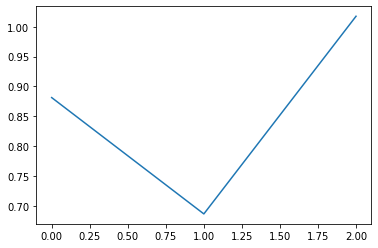

In [46]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
X = X_train.copy()
y = y_train.copy()
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = get_convLSTM_model(n_timesteps, n_features, n_outputs, n_length)
    history = train(model, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

#### Prediction on the holdout set

In [47]:
loss, accuracy, auc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
score = accuracy * 100
accuracies.append(round(score, 2))
aucs.append(round(auc * 100, 2))
print('\nAccuracy: %.3f%%' % score)
print('\nAUC:', round(auc, 4))


Accuracy: 59.259%

AUC: 0.8374


## 3. Results

In [48]:
def show_results(first, last):
    plt.rcParams['figure.figsize'] = (8,8)
    x = np.arange(len(model_names[first:last]))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies[first:last], width, label='Accuracy')
    rects2 = ax.bar(x + width/2, aucs[first:last], width, label='AUC * 100')

    ax.set_ylim(0, 100)
    ax.set_xticks(x, model_names[first:last])
    ax.legend()

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    plt.show()

### Body Modality (Skeleton) - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

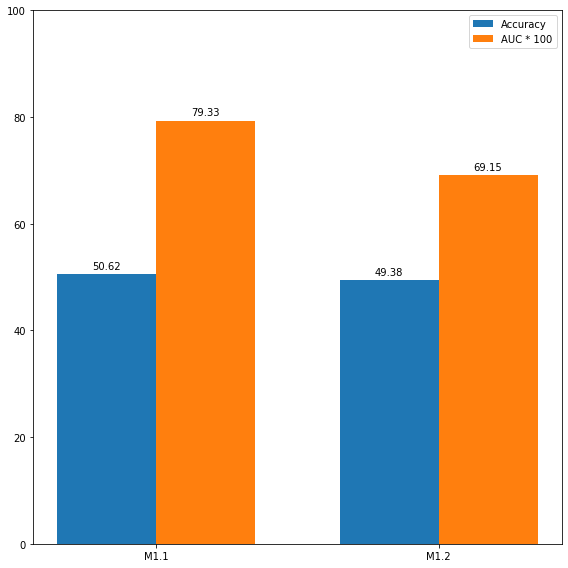

In [49]:
show_results(0, 2)

### Body Modality (Skeleton) - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

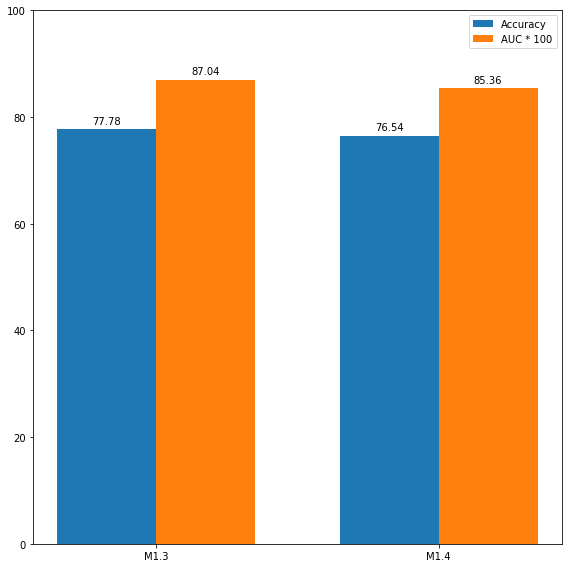

In [50]:
show_results(2, 4)

### Face Modality (Action Units) - Pain area prediction 

CNN+LSTM vs Convolutional LSTM

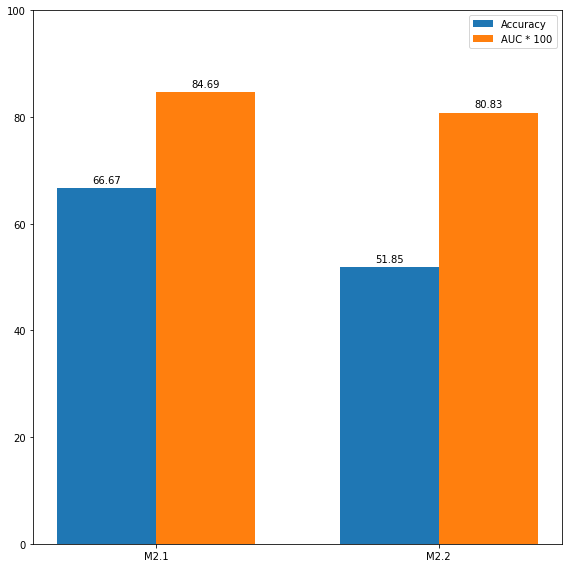

In [51]:
show_results(4, 6)

### Face Modality (Action Units) - Pain level prediction 

CNN+LSTM vs Convolutional LSTM

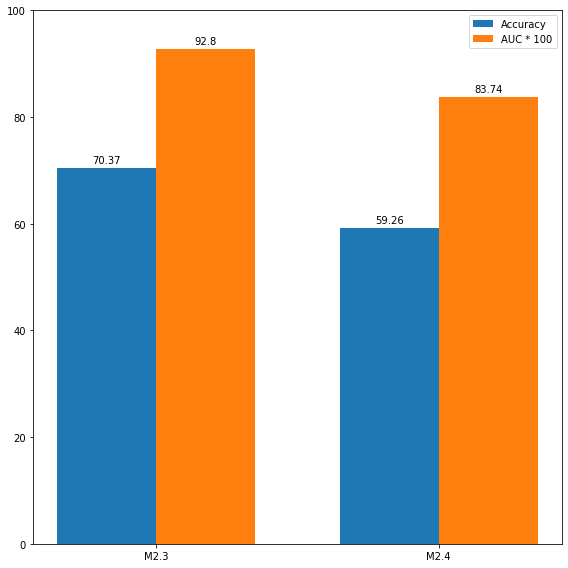

In [52]:
show_results(6, 8)